In [401]:
import json
import numpy as np
import csv
import scipy.stats.distributions
from scipy.spatial.transform import Rotation
import os
from matplotlib import pyplot as plt
import random
import math
import cvxpy as cp
import csv

# Helper Functions

### DIspersion filter

In [332]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals


### Find Head Angle

In [333]:
def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        



### find CHOR

In [334]:
class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle

def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    # is_not_zero = np.ones(fixation_angles.shape, dtype=bool)
    # is_not_zero = True

    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution



# Analyze The data from Bingjian, Lipan, Bogdan and Joonho

In [291]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BINGJIAN/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_LIPAN/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BOGDAN/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_JOONHO/collectedData"]
# input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_DENSE_DISTRIBUTION_PILOT/collectedData"]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['RandomPositions']
    # recording_file_names = ['randomCalibration', 'RandomPositions', 'anchoredDwell_0', 'anchoredDwell_2', 'anchoredDwell_3', 'anchoredDwell_4', 'anchoredDwell_5', 'anchoredDwell_6']
    # dwellTimeTargets = [0, 40, 60, -20, -40, -60]
    # comparing = [2,3,4,5,6,7]
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)
    

                

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11797/1184569283.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


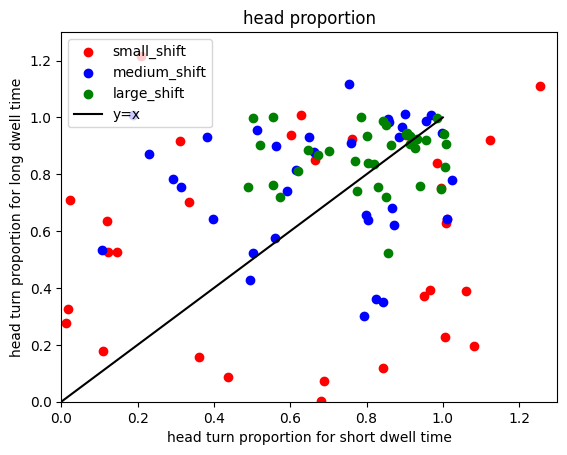

45.714285714285715 percent of the small gaze shift points fall above the y=x line
68.57142857142857 percent of the medium gaze shift points fall above the y=x line
62.857142857142854 percent of the large gaze shift points fall above the y=x line


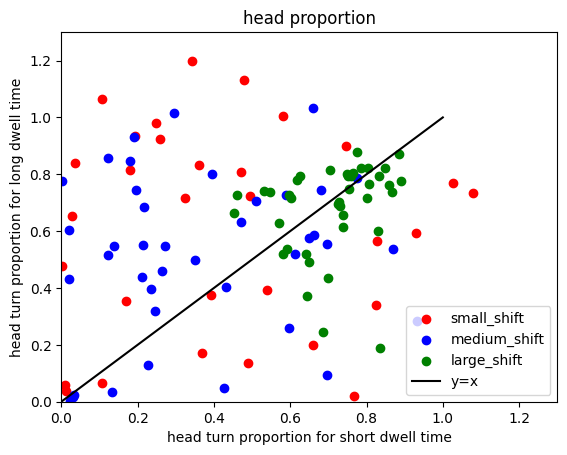

62.5 percent of the small gaze shift points fall above the y=x line
62.5 percent of the medium gaze shift points fall above the y=x line
42.5 percent of the large gaze shift points fall above the y=x line


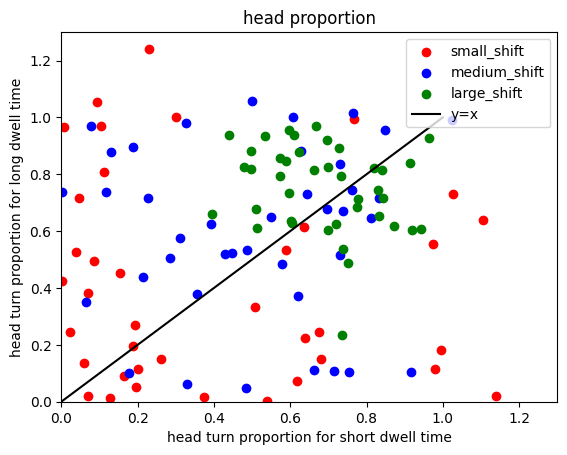

45.0 percent of the small gaze shift points fall above the y=x line
60.0 percent of the medium gaze shift points fall above the y=x line
60.0 percent of the large gaze shift points fall above the y=x line


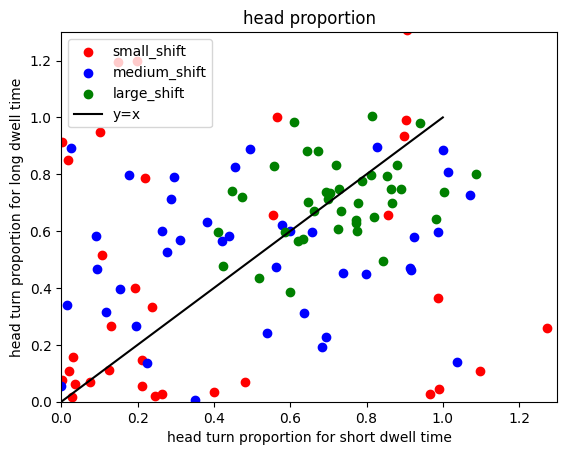

50.0 percent of the small gaze shift points fall above the y=x line
55.00000000000001 percent of the medium gaze shift points fall above the y=x line
45.0 percent of the large gaze shift points fall above the y=x line


In [292]:
all_start_end_tuples = []
for cp in [0, 1, 2, 3]:
    start_end_tuples = []
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    # get the target durations from the experimental setup file
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    for i in range(0, len(head_fixation_angles) - 1):
        start_end_tuples.append([fixation_angles[i], fixation_angles[i+1], target_present_duration[i+1], head_fixation_angles[i], head_fixation_angles[i+1]])

    head_turn_delta = []
    target_delta = []
    is_long_dwell = []
    is_short_dwell = []
    for i in range(len(start_end_tuples)):
        head_turn_delta.append(np.abs(start_end_tuples[i][4] - start_end_tuples[i][3]))
        target_delta.append(np.abs(start_end_tuples[i][0] - start_end_tuples[i][1]))
        if start_end_tuples[i][2] >= 0.6:
            is_long_dwell.append(True)
            is_short_dwell.append(False)
        else:
            is_long_dwell.append(False)
            is_short_dwell.append(True)
    target_delta = np.array(target_delta)
    sorted_indices = sorted(range(target_delta.shape[0]), key=lambda i: target_delta[i])
    target_delta = np.array([target_delta[i] for i in sorted_indices])
    head_turn_delta = np.array([head_turn_delta[i] for i in sorted_indices])
    is_short_dwell = np.array([is_short_dwell[i] for i in sorted_indices])
    is_long_dwell = np.array([is_long_dwell[i] for i in sorted_indices])

    # here head proportion is defined as the head turn delta divided by the target delta. 
    head_proportion_short_dwell = head_turn_delta[is_short_dwell] / target_delta[is_short_dwell]
    head_proportion_long_dwell = head_turn_delta[is_long_dwell] / target_delta[is_long_dwell]

    is_small_shift_and_short_dwell = np.arange(0, head_proportion_short_dwell.shape[0]/3, dtype=int)
    is_medium_shift_and_short_dwell = np.arange(head_proportion_short_dwell.shape[0]/3, 2 * head_proportion_short_dwell.shape[0]/3, dtype=int)
    is_large_shift_and_short_dwell = np.arange(2 * head_proportion_short_dwell.shape[0]/3, head_proportion_short_dwell.shape[0], dtype=int)
    is_small_shift_and_long_dwell = np.arange(0, head_proportion_long_dwell.shape[0]/3, dtype=int)
    is_medium_shift_and_long_dwell = np.arange(head_proportion_long_dwell.shape[0]/3, 2 * head_proportion_long_dwell.shape[0]/3, dtype=int)
    is_large_shift_and_long_dwell = np.arange(2 * head_proportion_long_dwell.shape[0]/3, head_proportion_long_dwell.shape[0], dtype=int)

    
    plt.xlim([0, 1.3])
    plt.ylim([0, 1.3])
    try:
        plt.scatter(head_proportion_short_dwell[is_small_shift_and_short_dwell], head_proportion_long_dwell[is_small_shift_and_long_dwell], label="small_shift", color="red")
        plt.scatter(head_proportion_short_dwell[is_medium_shift_and_short_dwell], head_proportion_long_dwell[is_medium_shift_and_long_dwell], label="medium_shift", color="blue")
        plt.scatter(head_proportion_short_dwell[is_large_shift_and_short_dwell], head_proportion_long_dwell[is_large_shift_and_long_dwell], label="large_shift", color="green")
    except:
        plt.scatter(head_proportion_short_dwell[3:], head_proportion_long_dwell, label="small_shift", color="red")
    plt.plot([0, 1], [0, 1], label="y=x", color="black")
    plt.legend()
    plt.title("head proportion")
    plt.xlabel("head turn proportion for short dwell time")
    plt.ylabel("head turn proportion for long dwell time")
    plt.show()
    try:
        print("{} percent of the small gaze shift points fall above the y=x line".format(np.sum(head_proportion_long_dwell[is_small_shift_and_long_dwell] > head_proportion_short_dwell[is_small_shift_and_short_dwell]) / (head_proportion_short_dwell[is_small_shift_and_short_dwell].shape[0]) * 100))
        print("{} percent of the medium gaze shift points fall above the y=x line".format(np.sum(head_proportion_long_dwell[is_medium_shift_and_long_dwell] > head_proportion_short_dwell[is_medium_shift_and_short_dwell]) / (head_proportion_short_dwell[is_medium_shift_and_short_dwell].shape[0]) * 100))
        print("{} percent of the large gaze shift points fall above the y=x line".format(np.sum(head_proportion_long_dwell[is_large_shift_and_long_dwell] > head_proportion_short_dwell[is_large_shift_and_short_dwell]) / (head_proportion_short_dwell[is_large_shift_and_short_dwell].shape[0]) * 100))
    except:   
        print("{} percent of the points fall above the y=x line".format(np.sum(head_proportion_long_dwell > head_proportion_short_dwell[3:]) / (head_proportion_short_dwell[3:].shape[0]) * 100))
    all_start_end_tuples.append(start_end_tuples)

In [293]:
class GaussianKernal2D:
    def __init__(self, loc, cov, amplitude):
        self.cov = cov
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.multivariate_normal(loc, cov)
    def cumulate(self, dim_1_values, dim_2_values, grid):
        # dim_1_values is the time array
        # dim_2_values is the value array, in which we will cumulate a series of GaussianKernals
        # grid is a 2d array
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                grid[i, j] += self.amplitude * self.gaussina.pdf([dim_1_values[i], dim_2_values[j]])
        return grid

In [296]:
overall_trend = []
over_all_trend_short_dwell = []
over_all_trend_long_dwell = []

for tup_i in range(len(all_start_end_tuples)):
    tup = all_start_end_tuples[tup_i]
    # the value of each tuple are: [fixation_angles[i], fixation_angles[i+1], target_present_duration[i+1], head_fixation_angles[i], head_fixation_angles[i+1]]
    tup = np.array(tup)
    width = 30
    axis_1 = np.linspace(-90, 90, 180)
    
    axis_2 = np.linspace(-90, 90, 180)
    grid_30_width = np.zeros((180, 180))
    grid_30_width_short_dwell = np.zeros((180, 180))
    grid_30_width_long_dwell = np.zeros((180, 180))

    for i in range(tup.shape[0]):
        # kernel = GaussianKernal2D([tup[i, 0], tup[i, 1]], [[width, 0], [0, width]], np.abs(tup[i, 4] - tup[i, 3])/np.abs(tup[i, 0] - tup[i, 1]))
        # kernal_30_width = GaussianKernal2D([tup[i, 0], tup[i, 1]], [[30, 0], [0, 30]], np.abs(tup[i, 4] - tup[i, 3])/np.abs(tup[i, 0] - tup[i, 1]))
        # grid_30_width = kernal_30_width.cumulate(axis_1, axis_2, grid_30_width)
        loc = [int(round(tup[i, 0])), int(round(tup[i, 1]))]
        value = np.abs(tup[i, 4] - tup[i, 3])/np.abs(tup[i, 0] - tup[i, 1])
        # value = np.abs(tup[i, 4] - tup[i, 3])
    
        if tup[i, 2] >= 0.6:
            # grid_30_width_long_dwell = kernal_30_width.cumulate(axis_1, axis_2, grid_30_width_long_dwell)
            grid_30_width_long_dwell[loc[0] + 89, loc[1] + 89] += value
        else:
            # grid_30_width_short_dwell = kernal_30_width.cumulate(axis_1, axis_2, grid_30_width_short_dwell)
            grid_30_width_short_dwell[loc[0] + 89, loc[1] + 89] += value
        
        grid_30_width[loc[0] + 89, loc[1] + 89] += value

    # convolve the grid with a 2d gaussian
    sigmaa = 5
    grid_30_width = scipy.ndimage.gaussian_filter(grid_30_width, sigma=sigmaa)
    grid_30_width_short_dwell = scipy.ndimage.gaussian_filter(grid_30_width_short_dwell, sigma=sigmaa)
    grid_30_width_long_dwell = scipy.ndimage.gaussian_filter(grid_30_width_long_dwell, sigma=sigmaa)
    

    overall_trend.append(grid_30_width)
    over_all_trend_short_dwell.append(grid_30_width_short_dwell)
    over_all_trend_long_dwell.append(grid_30_width_long_dwell)

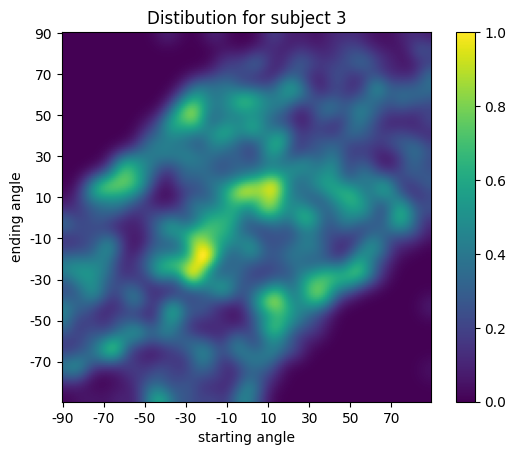

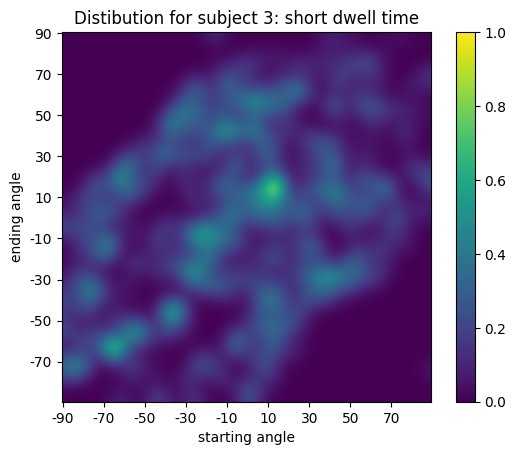

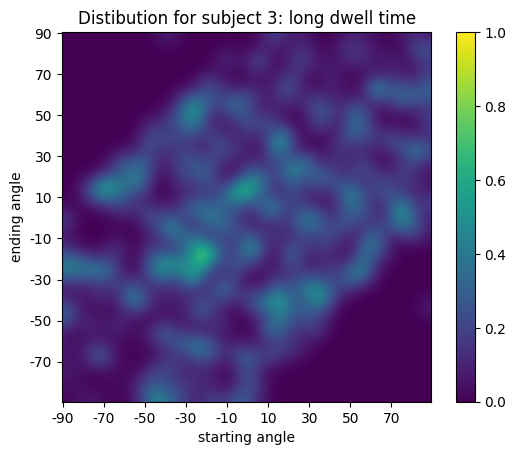

In [297]:
grid = np.sum(np.array(overall_trend), axis=0)
grid_short_dwell = np.sum(np.array(over_all_trend_short_dwell), axis=0)
grid_long_dwell = np.sum(np.array(over_all_trend_long_dwell), axis=0)
grid_short_dwell = grid_short_dwell / grid.max()
grid_long_dwell = grid_long_dwell / grid.max()
# print(grid_short_dwell.mean(), grid_long_dwell.mean())
grid = grid/grid.max()
plt.imshow(np.flip(grid, axis=0))
plt.title("Distibution for subject {}".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()

plt.show()

plt.imshow(np.flip(grid_short_dwell, axis=0))
plt.title("Distibution for subject {}: short dwell time".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()
plt.show()

plt.imshow(np.flip(grid_long_dwell, axis=0))
plt.title("Distibution for subject {}: long dwell time".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()
plt.show()

# Analyze Duration for long vs short

In [78]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_DURATION_LENGTH_PILOT/collectedData"]
# input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_JOONHO/collectedData"]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['RandomPositions']
    # recording_file_names = ['randomCalibration', 'RandomPositions', 'anchoredDwell_0', 'anchoredDwell_2', 'anchoredDwell_3', 'anchoredDwell_4', 'anchoredDwell_5', 'anchoredDwell_6']
    # dwellTimeTargets = [0, 40, 60, -20, -40, -60]
    # comparing = [2,3,4,5,6,7]
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input) 

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11797/1761273684.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


241


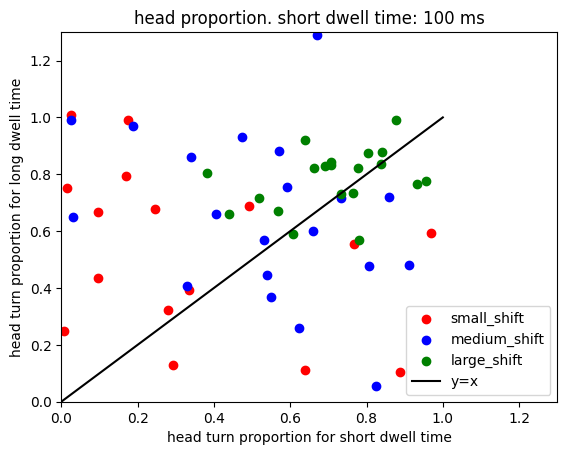

65.0 percent of the points fall above the y=x line
70.0 percent of the small gaze shift points fall above the y=x line
55.00000000000001 percent of the medium gaze shift points fall above the y=x line
70.0 percent of the large gaze shift points fall above the y=x line


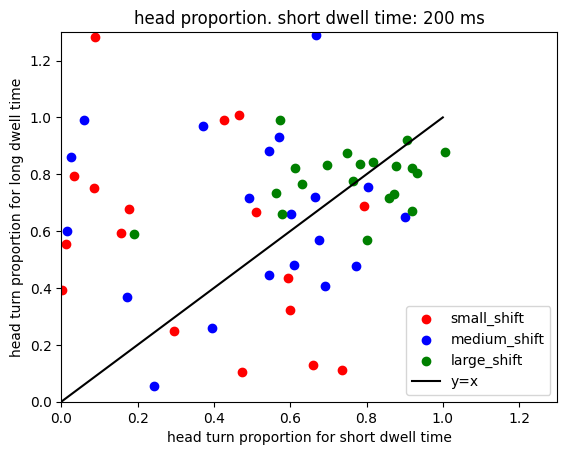

60.0 percent of the points fall above the y=x line
65.0 percent of the small gaze shift points fall above the y=x line
55.00000000000001 percent of the medium gaze shift points fall above the y=x line
60.0 percent of the large gaze shift points fall above the y=x line


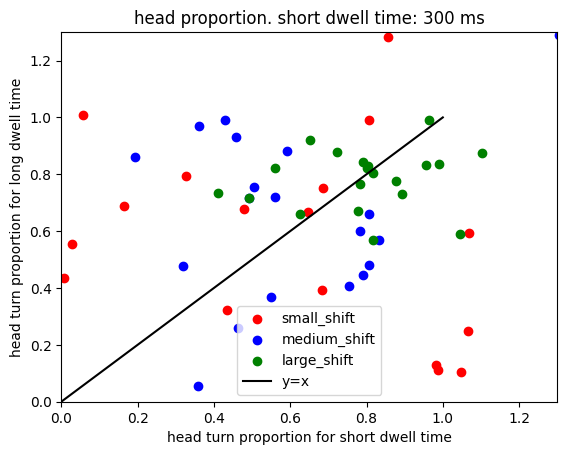

51.66666666666667 percent of the points fall above the y=x line
60.0 percent of the small gaze shift points fall above the y=x line
45.0 percent of the medium gaze shift points fall above the y=x line
50.0 percent of the large gaze shift points fall above the y=x line


In [97]:
start_end_tuples = []

for cp in [0]:
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0, 0.01)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    print(len(target_fixations_intervals))
    # get the target durations from the experimental setup file
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    for i in range(0, len(head_fixation_angles) - 1):
        start_end_tuples.append([fixation_angles[i], fixation_angles[i+1], target_present_duration[i+1], head_fixation_angles[i], head_fixation_angles[i+1]])
    head_turn_delta = []
    target_delta = []
    is_100ms_dwell = []
    is_200ms_dwell = []
    is_300ms_dwell = []
    is_1000ms_dwell = []
    for i in range(len(start_end_tuples)):
        head_turn_delta.append(np.abs(start_end_tuples[i][4] - start_end_tuples[i][3]))
        target_delta.append(np.abs(start_end_tuples[i][0] - start_end_tuples[i][1]))
        if start_end_tuples[i][2] <= 0.12:
            is_100ms_dwell.append(True)
            is_200ms_dwell.append(False)
            is_300ms_dwell.append(False)
            is_1000ms_dwell.append(False)
        elif start_end_tuples[i][2] <= 0.22:
            is_100ms_dwell.append(False)
            is_200ms_dwell.append(True)
            is_300ms_dwell.append(False)
            is_1000ms_dwell.append(False)
        elif start_end_tuples[i][2] <= 0.32:
            is_100ms_dwell.append(False)
            is_200ms_dwell.append(False)
            is_300ms_dwell.append(True)
            is_1000ms_dwell.append(False)
        else:
            is_100ms_dwell.append(False)
            is_200ms_dwell.append(False)
            is_300ms_dwell.append(False)
            is_1000ms_dwell.append(True)
    target_delta = np.array(target_delta)
    sorted_indices = sorted(range(target_delta.shape[0]), key=lambda i: target_delta[i])
    target_delta = np.array([target_delta[i] for i in sorted_indices])
    head_turn_delta = np.array([head_turn_delta[i] for i in sorted_indices])
    is_100ms_dwell = np.array([is_100ms_dwell[i] for i in sorted_indices])
    is_200ms_dwell = np.array([is_200ms_dwell[i] for i in sorted_indices])
    is_300ms_dwell = np.array([is_300ms_dwell[i] for i in sorted_indices])
    is_1000ms_dwell = np.array([is_1000ms_dwell[i] for i in sorted_indices])


    dwells = [is_100ms_dwell, is_200ms_dwell, is_300ms_dwell]
    is_long_dwell = is_1000ms_dwell
    for idd in range(3):
        is_short_dwell = dwells[idd]
    # here head proportion is defined as the head turn delta divided by the target delta. 
        head_proportion_short_dwell = head_turn_delta[is_short_dwell] / target_delta[is_short_dwell]
        head_proportion_long_dwell = head_turn_delta[is_long_dwell] / target_delta[is_long_dwell]

        is_small_shift_and_short_dwell = np.arange(0, head_proportion_short_dwell.shape[0]/3, dtype=int)
        is_medium_shift_and_short_dwell = np.arange(head_proportion_short_dwell.shape[0]/3, 2 * head_proportion_short_dwell.shape[0]/3, dtype=int)
        is_large_shift_and_short_dwell = np.arange(2 * head_proportion_short_dwell.shape[0]/3, head_proportion_short_dwell.shape[0], dtype=int)
        is_small_shift_and_long_dwell = np.arange(0, head_proportion_long_dwell.shape[0]/3, dtype=int)
        is_medium_shift_and_long_dwell = np.arange(head_proportion_long_dwell.shape[0]/3, 2 * head_proportion_long_dwell.shape[0]/3, dtype=int)
        is_large_shift_and_long_dwell = np.arange(2 * head_proportion_long_dwell.shape[0]/3, head_proportion_long_dwell.shape[0], dtype=int)

        
        plt.xlim([0, 1.3])
        plt.ylim([0, 1.3])

        plt.scatter(head_proportion_short_dwell[is_small_shift_and_short_dwell], head_proportion_long_dwell[is_small_shift_and_long_dwell], label="small_shift", color="red")
        plt.scatter(head_proportion_short_dwell[is_medium_shift_and_short_dwell], head_proportion_long_dwell[is_medium_shift_and_long_dwell], label="medium_shift", color="blue")
        plt.scatter(head_proportion_short_dwell[is_large_shift_and_short_dwell], head_proportion_long_dwell[is_large_shift_and_long_dwell], label="large_shift", color="green")

        plt.plot([0, 1], [0, 1], label="y=x", color="black")
        plt.legend()
        plt.title("head proportion. short dwell time = {} ms".format(100 * (idd + 1)))
        plt.xlabel("head turn proportion for short dwell time")
        plt.ylabel("head turn proportion for long dwell time")
        plt.show()
        print("{} percent of the points fall above the y=x line".format(np.sum(head_proportion_long_dwell > head_proportion_short_dwell) / (head_proportion_short_dwell.shape[0]) * 100))
        print("{} percent of the small gaze shift points fall above the y=x line".format(np.sum(head_proportion_long_dwell[is_small_shift_and_long_dwell] > head_proportion_short_dwell[is_small_shift_and_short_dwell]) / (head_proportion_short_dwell[is_small_shift_and_short_dwell].shape[0]) * 100))
        print("{} percent of the medium gaze shift points fall above the y=x line".format(np.sum(head_proportion_long_dwell[is_medium_shift_and_long_dwell] > head_proportion_short_dwell[is_medium_shift_and_short_dwell]) / (head_proportion_short_dwell[is_medium_shift_and_short_dwell].shape[0]) * 100))
        print("{} percent of the large gaze shift points fall above the y=x line".format(np.sum(head_proportion_long_dwell[is_large_shift_and_long_dwell] > head_proportion_short_dwell[is_large_shift_and_short_dwell]) / (head_proportion_short_dwell[is_large_shift_and_short_dwell].shape[0]) * 100))        


# Analyze response from crafted distribution

In [498]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_DENSE_DISTRIBUTION_PILOT/collectedData"]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['RandomPositions']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)
    

                

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11797/2147364244.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11797/2147364244.py:79: RuntimeWarning: divide by zero encountered in divide
  head_proportion_long_dwell = head_turn_delta_long_dwell / target_delta_long_dwell


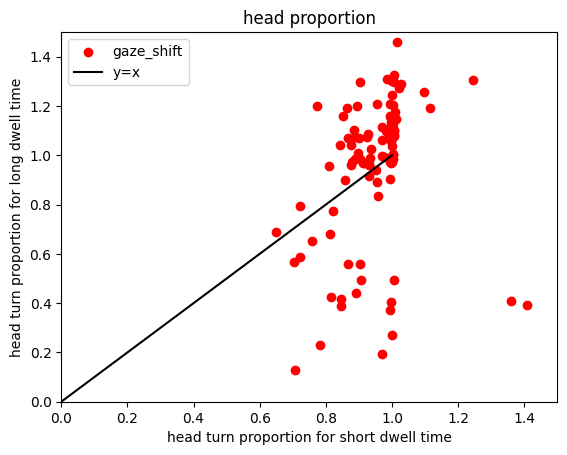

73.64341085271317 percent of the points fall above the y=x line


In [499]:
all_start_end_tuples = []
for cp in [0]:
    start_end_tuples = []
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0, 0.05)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    # get the target durations from the experimental setup file
    target_angle = all_target_input[cp]["angle"]
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    for i in range(0, len(head_fixation_angles) - 1):
        start_end_tuples.append([fixation_angles[i], fixation_angles[i+1], target_present_duration[i+1], head_fixation_angles[i], head_fixation_angles[i+1]])
    head_turn_delta = []
    target_delta = []
    is_long_dwell = []
    is_short_dwell = []
    for i in range(len(start_end_tuples)):
        head_turn_delta.append(np.abs(start_end_tuples[i][4] - start_end_tuples[i][3]))
        target_delta.append(np.abs(start_end_tuples[i][0] - start_end_tuples[i][1]))
        if start_end_tuples[i][2] >= 0.6:
            is_long_dwell.append(True)
            is_short_dwell.append(False)
        else:
            is_long_dwell.append(False)
            is_short_dwell.append(True)
    # get all the points to be aligned
    start_end_tuples_arr = np.array(start_end_tuples)
    short_dwell_pairs = []
    long_dwell_pairs = []
    for i in range(0, len(start_end_tuples_arr[is_long_dwell])):
        tup = start_end_tuples_arr[is_long_dwell][i]
        for j in range(0, len(start_end_tuples_arr[is_short_dwell])):
            tup2 = start_end_tuples_arr[is_short_dwell][j]
            if abs(tup[0] - tup2[0]) <= 1 and abs(tup[1] - tup2[1]) <= 1:
                long_dwell_pairs.append(tup)
                short_dwell_pairs.append(tup2)
                break    
    long_dwell_pairs = np.array(long_dwell_pairs)
    short_dwell_pairs = np.array(short_dwell_pairs)
    target_delta_short_dwell = np.abs(short_dwell_pairs[1, 1] - short_dwell_pairs[:, 0])
    head_turn_delta_short_dwell = np.abs(short_dwell_pairs[1, 4] - short_dwell_pairs[:, 3])
    target_delta_long_dwell = np.abs(long_dwell_pairs[1, 1] - long_dwell_pairs[:, 0])
    head_turn_delta_long_dwell = np.abs(long_dwell_pairs[1, 4] - long_dwell_pairs[:, 3])
    
    # here head proportion is defined as the head turn delta divided by the target delta. 
    head_proportion_short_dwell = head_turn_delta_short_dwell / target_delta_short_dwell
    head_proportion_long_dwell = head_turn_delta_long_dwell / target_delta_long_dwell

    is_small_shift_and_short_dwell = np.arange(0, head_proportion_short_dwell.shape[0]/3, dtype=int)
    is_medium_shift_and_short_dwell = np.arange(head_proportion_short_dwell.shape[0]/3, 2 * head_proportion_short_dwell.shape[0]/3, dtype=int)
    is_large_shift_and_short_dwell = np.arange(2 * head_proportion_short_dwell.shape[0]/3, head_proportion_short_dwell.shape[0], dtype=int)
    is_small_shift_and_long_dwell = np.arange(0, head_proportion_long_dwell.shape[0]/3, dtype=int)
    is_medium_shift_and_long_dwell = np.arange(head_proportion_long_dwell.shape[0]/3, 2 * head_proportion_long_dwell.shape[0]/3, dtype=int)
    is_large_shift_and_long_dwell = np.arange(2 * head_proportion_long_dwell.shape[0]/3, head_proportion_long_dwell.shape[0], dtype=int)

    
    plt.xlim([0, 1.5])
    plt.ylim([0, 1.5])
    plt.scatter(head_proportion_short_dwell, head_proportion_long_dwell, label="gaze_shift", color="red")
    plt.plot([0, 1], [0, 1], label="y=x", color="black")
    plt.legend()
    plt.title("head proportion")
    plt.xlabel("head turn proportion for short dwell time")
    plt.ylabel("head turn proportion for long dwell time")
    plt.show()
    print("{} percent of the points fall above the y=x line".format(np.sum(head_proportion_long_dwell > head_proportion_short_dwell) / (head_proportion_short_dwell.shape[0]) * 100))
    all_start_end_tuples.append(start_end_tuples)

In [501]:
print(len(all_start_end_tuples[0]))

468


In [399]:
overall_trend = []
over_all_trend_short_dwell = []
over_all_trend_long_dwell = []

for tup_i in range(len(all_start_end_tuples)):
    tup = all_start_end_tuples[tup_i]
    # the value of each tuple are: [fixation_angles[i], fixation_angles[i+1], target_present_duration[i+1], head_fixation_angles[i], head_fixation_angles[i+1]]
    tup = np.array(tup)
    axis_1 = np.linspace(-90, 90, 180)
    
    axis_2 = np.linspace(-90, 90, 180)
    grid_30_width = np.zeros((180, 180))
    grid_30_width_short_dwell = np.zeros((180, 180))
    grid_30_width_long_dwell = np.zeros((180, 180))

    for i in range(tup.shape[0]):
        # kernel = GaussianKernal2D([tup[i, 0], tup[i, 1]], [[width, 0], [0, width]], np.abs(tup[i, 4] - tup[i, 3])/np.abs(tup[i, 0] - tup[i, 1]))
        # kernal_30_width = GaussianKernal2D([tup[i, 0], tup[i, 1]], [[30, 0], [0, 30]], np.abs(tup[i, 4] - tup[i, 3])/np.abs(tup[i, 0] - tup[i, 1]))
        # grid_30_width = kernal_30_width.cumulate(axis_1, axis_2, grid_30_width)
        loc = [int(round(tup[i, 0])), int(round(tup[i, 1]))]
        value = np.abs(tup[i, 4] - tup[i, 3])/np.abs(tup[i, 0] - tup[i, 1])
        if tup[i, 2] >= 0.6:
            # grid_30_width_long_dwell = kernal_30_width.cumulate(axis_1, axis_2, grid_30_width_long_dwell)
            grid_30_width_long_dwell[loc[0] + 90, loc[1] + 90] += value
        else:
            # grid_30_width_short_dwell = kernal_30_width.cumulate(axis_1, axis_2, grid_30_width_short_dwell)
            grid_30_width_short_dwell[loc[0] + 90, loc[1] + 90] += value
        grid_30_width[loc[0] + 90, loc[1] + 90] += value
    
    # convolve the grid with a 2d gaussian
    sigmaa = 8
    grid_30_width = scipy.ndimage.gaussian_filter(grid_30_width, sigma=sigmaa)
    grid_30_width_short_dwell = scipy.ndimage.gaussian_filter(grid_30_width_short_dwell, sigma=sigmaa)
    grid_30_width_long_dwell = scipy.ndimage.gaussian_filter(grid_30_width_long_dwell, sigma=sigmaa)
    

    overall_trend.append(grid_30_width)
    over_all_trend_short_dwell.append(grid_30_width_short_dwell)
    over_all_trend_long_dwell.append(grid_30_width_long_dwell)

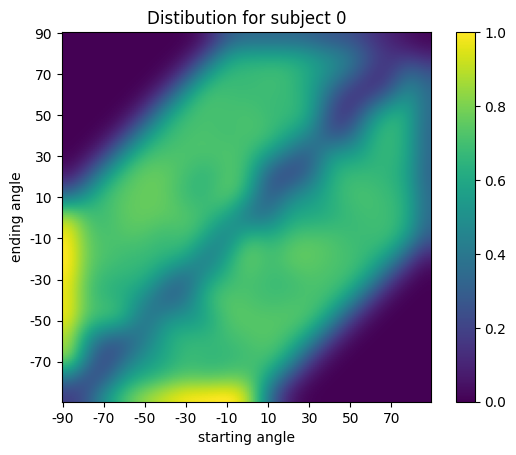

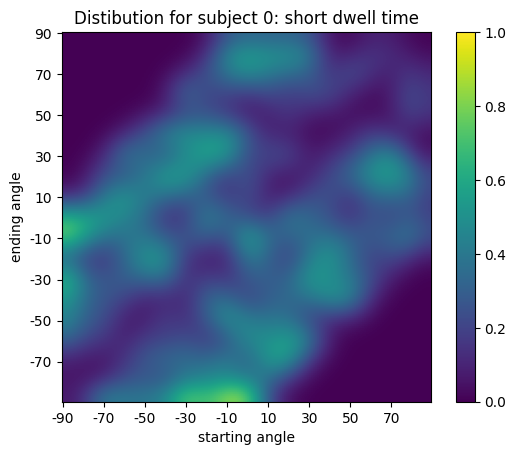

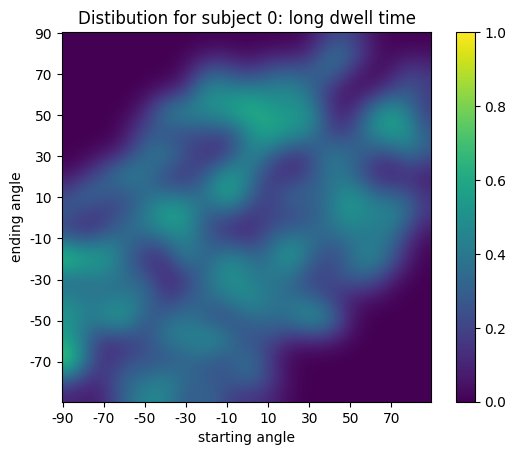

In [400]:
grid = np.sum(np.array(overall_trend), axis=0)
grid_short_dwell = np.sum(np.array(over_all_trend_short_dwell), axis=0)
grid_long_dwell = np.sum(np.array(over_all_trend_long_dwell), axis=0)
grid_short_dwell = grid_short_dwell / grid.max()
grid_long_dwell = grid_long_dwell / grid.max()
grid = grid/grid.max()
plt.imshow(np.flip(grid, axis=0))
plt.title("Distibution for subject {}".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()

plt.show()

plt.imshow(np.flip(grid_short_dwell, axis=0))
plt.title("Distibution for subject {}: short dwell time".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()
plt.show()
plt.imshow(np.flip(grid_long_dwell, axis=0))
plt.title("Distibution for subject {}: long dwell time".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()
plt.show()

## Fit optimization model

In [470]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid_search(results, N):
    """
    Plot the results of a grid search on N 2D grids using seaborn.

    Parameters:
    results (list): A list of tuples in the format [(param1, param2, param3), value].
    N (int): The number of values for the first parameter.

    Returns:
    None
    """
    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['w_target', 'w_prev', 'w_eccentrivity', 'value'])
    
    # Loop over the values of the first parameter
    for i in [1]:
        # Filter the DataFrame to select the rows with the current value of the first parameter
        df_i = df[df['w_target'] == i]
        
        # Pivot the filtered DataFrame to create a 2D grid
        # grid = df_i.pivot('param2', 'param3', 'value')
        grid = df_i
        # Create a heatmap plot of the grid
        ax = sns.heatmap(grid, annot=True, fmt=".3f", linewidths=.5, cmap='coolwarm')
        
        # Set the plot title and labels
        ax.set_title(f'Grid Search Results)')
        ax.set_xlabel('w_prev')
        ax.set_ylabel('w_eccentrivity')
        
        # Show the plot
        plt.show()
class SimplestOptimizationModel:
    def __init__(self):
        self.essentricity_weight = 0.5
        self.target_weight = 0.5
        self.previous_target_weight = 0.5
    def solve_head_angle(self, previous_target, current_target, previous_head):
        neck_angle_azi = cp.Variable(1)
        # optimize for neck angle azi
        # objective = cp.Minimize(min(gaze_time, 1) * (neck_angle_azi - prior_head_angles[i, 0]) ** 2
        #                         + (neck_angle_azi - listener_angle[0])**2)
        objective = cp.Minimize(self.essentricity_weight * (neck_angle_azi) ** 2 +
                                self.target_weight * (neck_angle_azi - current_target) ** 2 +
                                self.previous_target_weight * (neck_angle_azi - previous_target) ** 2)
        problem = cp.Problem(objective, [])
        opt = problem.solve()
        return neck_angle_azi.value[0]
    def solve_list_of_head_angles(self, target_angle_list):
        output_angles = [target_angle_list[0]]
        for i in range(1, len(target_angle_list)):
            output_angles.append(self.solve_head_angle(target_angle_list[i-1], target_angle_list[i], output_angles[-1]))
        return output_angles
    def load_weights(self, target_weight, essentricity_weight, previous_target_weight):
        self.essentricity_weight = essentricity_weight
        self.target_weight = target_weight
        self.previous_target_weight = previous_target_weight


class ShortLongOptimizationModel:
    def __init__(self):
        self.essentricity_weight_short = 0.5
        self.target_weight_short = 0.5
        self.previous_target_weight_short = 0.5
        self.essentricity_weight_long = 0.5
        self.target_weight_long = 0.5
        self.previous_target_weight_long = 0.5
    def solve_head_angle(self, previous_target, current_target, previous_head, duration):
        neck_angle_azi = cp.Variable(1)
        if duration <= 0.2:    
            objective = cp.Minimize(self.essentricity_weight_short * (neck_angle_azi) ** 2 +
                                    self.target_weight_short * (neck_angle_azi - current_target) ** 2 +
                                    self.previous_target_weight_short * (neck_angle_azi - previous_target) ** 2)
        else:
            objective = cp.Minimize(self.essentricity_weight_long * (neck_angle_azi) ** 2 +
                                    self.target_weight_long * (neck_angle_azi - current_target) ** 2 +
                                    self.previous_target_weight_long * (neck_angle_azi - previous_target) ** 2)
        problem = cp.Problem(objective, [])
        opt = problem.solve()
        return neck_angle_azi.value[0]
    def solve_list_of_head_angles(self, target_angle_list, duration_list):
        output_angles = [target_angle_list[0]]
        for i in range(1, len(target_angle_list)):
            output_angles.append(self.solve_head_angle(target_angle_list[i-1], target_angle_list[i], output_angles[-1], duration_list[i]))
        return output_angles
    def load_weights_short(self, target_weight, essentricity_weight, previous_target_weight):
        self.essentricity_weight_short = essentricity_weight
        self.target_weight_short = target_weight
        self.previous_target_weight_short = previous_target_weight
    def load_weights_long(self, target_weight, essentricity_weight, previous_target_weight):
        self.essentricity_weight_long = essentricity_weight
        self.target_weight_long = target_weight
        self.previous_target_weight_long = previous_target_weight
    

In [471]:
# input
gaze_angles = []
head_angles = []
prev_head_angles = []
durations = []
gaze_angles.append(start_end_tuples_arr[0][0])
head_angles.append(start_end_tuples_arr[0][3])
durations.append(1)
prev_head_angles.append(0)
for i in range(0, len(start_end_tuples_arr)):
    # start_end_tuples_arr contains the following values: [fixation_angles[i], fixation_angles[i+1], target_present_duration[i+1], head_fixation_angles[i], head_fixation_angles[i+1]]
    gaze_angles.append(start_end_tuples_arr[i][1])
    head_angles.append(start_end_tuples_arr[i][4])
    prev_head_angles.append(start_end_tuples_arr[i][3])
    durations.append(start_end_tuples_arr[i][2])

gaze_angles = np.array(gaze_angles)
head_angles = np.array(head_angles)
durations = np.array(durations)


from itertools import product

def hyperparameter_search_SimplestOptimizationModel(hyperparameters, gaze_angles, head_angles):
    """
    Perform a hyperparameter search using grid search.

    Parameters:
    model (object): A machine learning model object with a .fit method.
    hyperparameters (dict): A dictionary of hyperparameters to search over.
    X (array-like): The input data for the model.
    y (array-like): The target data for the model.

    Returns:
    best_params (dict): The best hyperparameters found.
    """
    # Get all combinations of hyperparameters
    all_params = product(*hyperparameters.values())

    # Initialize variables to keep track of best model performance
    best_score = float('inf')
    best_params = None
    values = []
    # Loop over all hyperparameter combinations
    rt_params = []
    for params in all_params:
        # Set hyperparameters for the model
        model_i = SimplestOptimizationModel()
        model_i.load_weights(params[0], params[1], params[2])
        output = model_i.solve_list_of_head_angles(gaze_angles)
        # Calculate model performance using cross-validation
        output = np.array(output)
        mean_score = np.abs(output - head_angles).mean()
        # Update best score and parameters if current score is better
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
        values.append(mean_score)
        rt_params.append([params[0], params[1], params[2], mean_score])
        print(rt_params[-1])
    print(best_params, best_score)
    return best_params, rt_params

def hyperparameter_search_ShortLongOptimizationModel(hyperparameters, gaze_angles, head_angles, durations):
    """
    Perform a hyperparameter search using grid search.

    Parameters:
    model (object): A machine learning model object with a .fit method.
    hyperparameters (dict): A dictionary of hyperparameters to search over.
    X (array-like): The input data for the model.
    y (array-like): The target data for the model.

    Returns:
    best_params (dict): The best hyperparameters found.
    """
    # Get all combinations of hyperparameters
    all_params = product(*hyperparameters.values())

    # Initialize variables to keep track of best model performance
    best_score_long_duration = float('inf')
    best_params_long_duration = None

    best_score_short_duration = float('inf')
    best_params_short_duration = None

    values_short_duration = []
    values_long_duration = []
    
    # Loop over all hyperparameter combinations
    rt_params_short_duration = []
    rt_params_long_duration = []
    
    for params in all_params:
        # Set hyperparameters for the model
        model_i = ShortLongOptimizationModel()
        model_i.load_weights_short(params[0], params[1], params[2])
        model_i.load_weights_long(params[0], params[1], params[2])
        output = model_i.solve_list_of_head_angles(gaze_angles, durations)
        # Calculate model performance using cross-validation
        output = np.array(output)
        output_short_duration = output[durations <= 0.2]
        output_long_duration = output[durations > 0.2]
        
        head_anlges_short_duration = head_angles[durations <= 0.2]
        head_anlges_long_duration = head_angles[durations > 0.2]

        # Update best score and parameters if current score is better
        mean_score_short = np.abs(output_short_duration - head_anlges_short_duration).mean()
        if mean_score_short < best_score_short_duration:
            best_score_short_duration = mean_score_short
            best_params_short_duration = params

        # do the same for the long duration model
        mean_score_long = np.abs(output_long_duration - head_anlges_long_duration).mean()
        if mean_score_long < best_score_long_duration:
            best_score_long_duration = mean_score_long
            best_params_long_duration = params

        
        values_short_duration.append(mean_score_short)
        values_long_duration.append(mean_score_long)
        rt_params_short_duration.append([params[0], params[1], params[2], mean_score_short])
        rt_params_long_duration.append([params[0], params[1], params[2], mean_score_long])

        print("for params: {}, {}, {} ".format(params[0], params[1], params[2]) + "the values for short duration is: {}".format(mean_score_short), "the values for long duration is: {}".format(mean_score_long))
    
    print(best_params_long_duration, best_score_long_duration)
    print(best_params_short_duration, best_score_short_duration)
    return rt_params_long_duration, rt_params_short_duration

In [472]:
hyperparameters = {
    'target_weight': [1],
    'essentricity_weight': np.arange(0, 0.3, 0.05),
    'previous_target_weight': np.arange(0, 0.3, 0.05),
}

__, output = hyperparameter_search_SimplestOptimizationModel(hyperparameters, gaze_angles, head_angles)

# here is the version if we use previous target angle
best_hyperparameters_simplest_model = {
    'target_weight': [1],
    'essentricity_weight': [0.05],
    'previous_target_weight': [0.05],
    'value': 3.143486780568035
}

[1, 0.0, 0.0, 3.8758738559037926]
[1, 0.0, 0.05, 3.7004224124846603]
[1, 0.0, 0.1, 4.014208292681002]
[1, 0.0, 0.15000000000000002, 4.75371710115511]
[1, 0.0, 0.2, 5.742324879330812]
[1, 0.0, 0.25, 6.824164550687229]
[1, 0.05, 0.0, 3.3342245236043415]
[1, 0.05, 0.05, 3.171304141309259]
[1, 0.05, 0.1, 3.6877273686815917]
[1, 0.05, 0.15000000000000002, 4.630254173853395]
[1, 0.05, 0.2, 5.747994575582579]
[1, 0.05, 0.25, 6.909969710605151]
[1, 0.1, 0.0, 3.3317939778297654]
[1, 0.1, 0.05, 3.3744182786814467]
[1, 0.1, 0.1, 4.047215804307024]
[1, 0.1, 0.15000000000000002, 5.087567087624068]
[1, 0.1, 0.2, 6.210350904114652]
[1, 0.1, 0.25, 7.30626491365255]
[1, 0.15000000000000002, 0.0, 3.7730241714243995]
[1, 0.15000000000000002, 0.05, 4.063630765608516]
[1, 0.15000000000000002, 0.1, 4.847245210942063]
[1, 0.15000000000000002, 0.15000000000000002, 5.833310783867273]
[1, 0.15000000000000002, 0.2, 6.8819947051306345]
[1, 0.15000000000000002, 0.25, 7.912089815227555]
[1, 0.2, 0.0, 4.559097752138

In [469]:
hyperparameters = {
    'target_weight': [1],
    'essentricity_weight': np.arange(0, 0.3, 0.05),
    'previous_target_weight': np.arange(0, 0.3, 0.05),
}
hyperparameter_search_ShortLongOptimizationModel(hyperparameters, gaze_angles, head_angles, durations)

hyperparameters_shortlong_optimizationModel = {
    'target_weight_long': [1],
    'essentricity_weight_long': [0.05],
    'previous_target_weight_long': [0],
    'value': [2.68],
    
    'target_weight_short': [1],
    'essentricity_weight_short': [0.1],
    'previous_target_weight_short': [0.05],
    'value' : [3.50]
}

for params: 1, 0.0, 0.0 the values for short duration is: 4.690864769050474 the values for long duration is: 3.0574000756069113
for params: 1, 0.0, 0.05 the values for short duration is: 4.2672406712643065 the values for long duration is: 3.13118185345382
for params: 1, 0.0, 0.1 the values for short duration is: 4.3282669036822785 the values for long duration is: 3.6988075508634815
for params: 1, 0.0, 0.15000000000000002 the values for short duration is: 4.957333147829747 the values for long duration is: 4.5492309004348535
for params: 1, 0.0, 0.2 the values for short duration is: 5.862965654284545 the values for long duration is: 5.6211685455097555
for params: 1, 0.0, 0.25 the values for short duration is: 6.907319172727003 the values for long duration is: 6.740654567014805
for params: 1, 0.0, 0.30000000000000004 the values for short duration is: 8.028909996722785 the values for long duration is: 7.845368763421214
for params: 1, 0.0, 0.35000000000000003 the values for short duration is

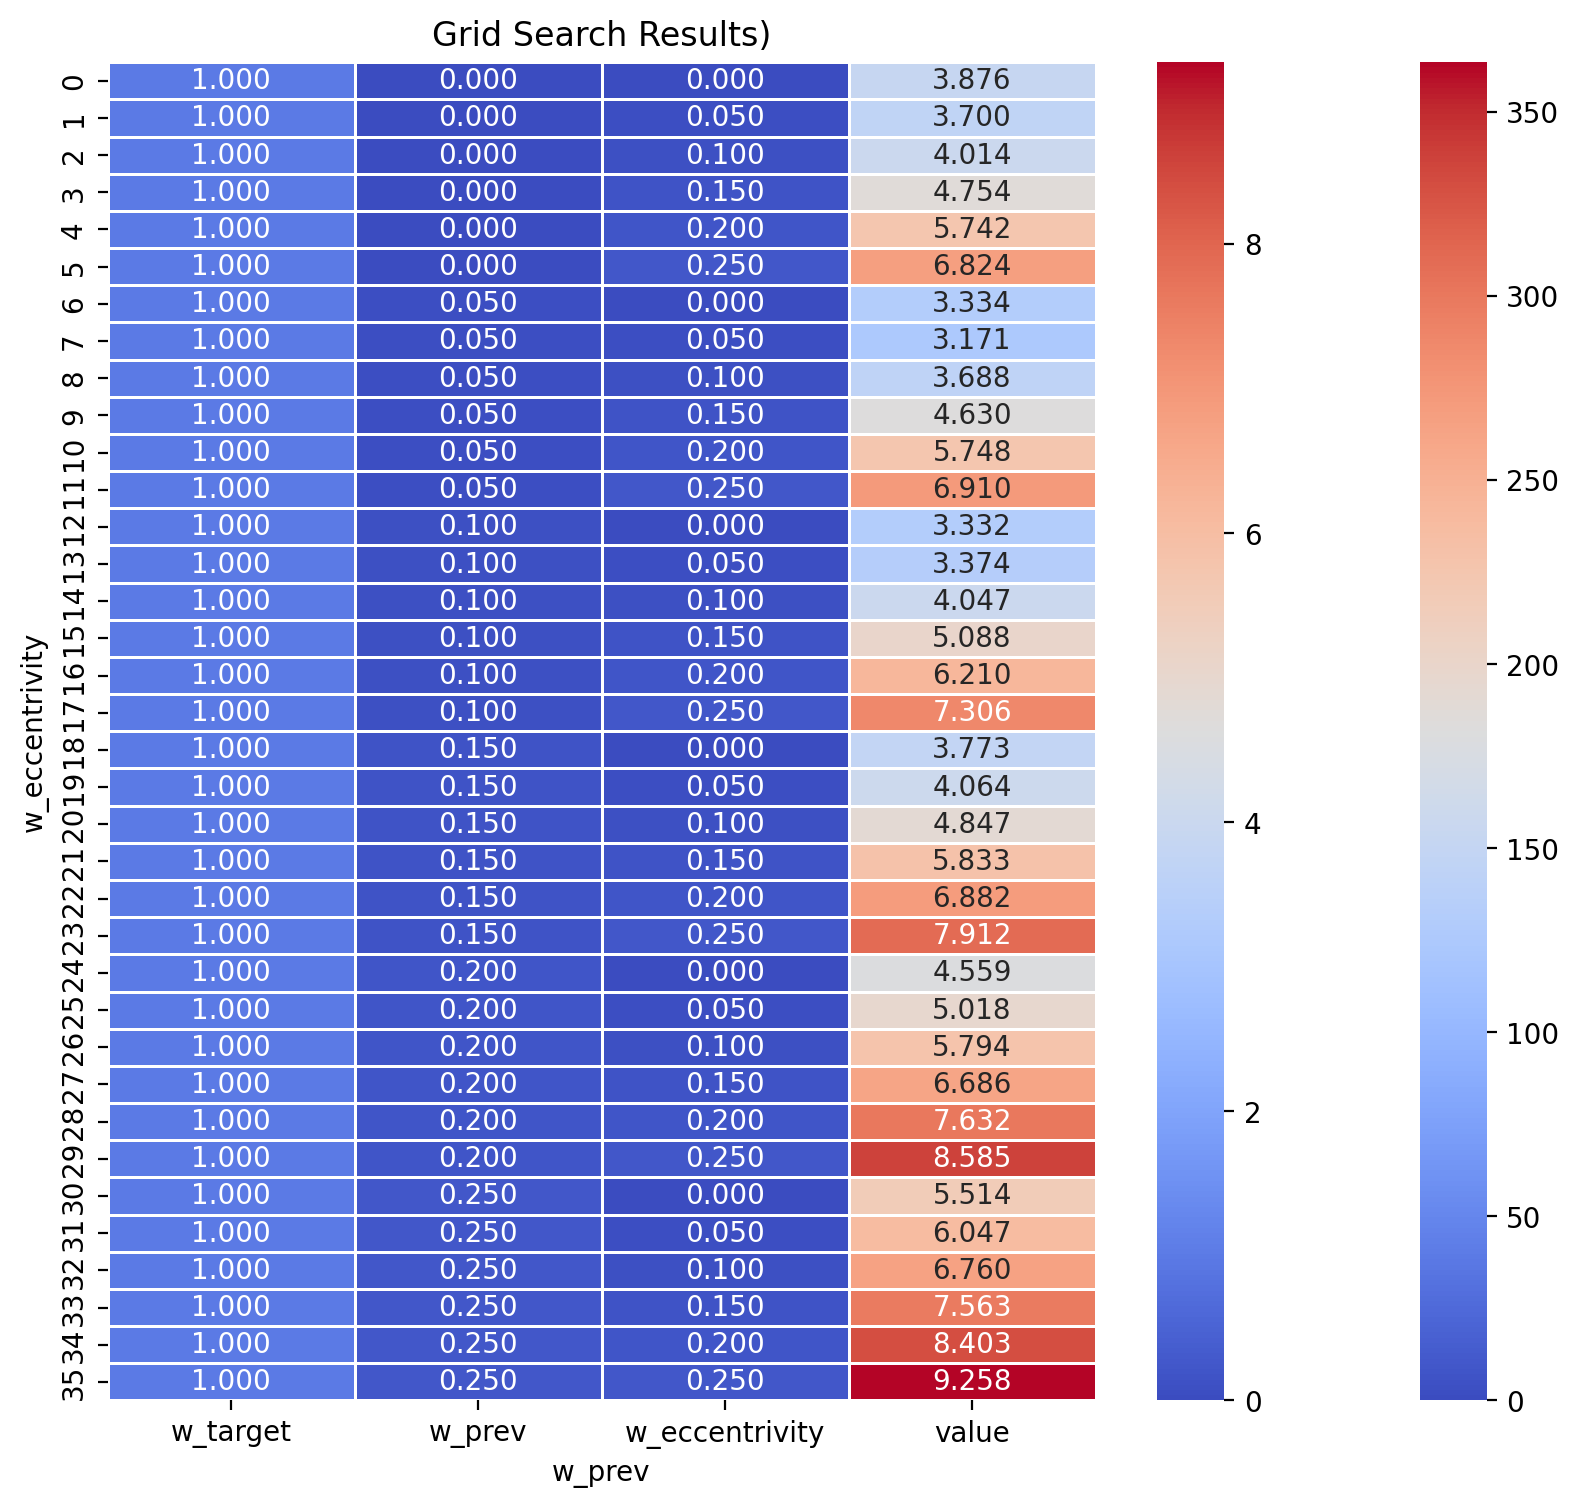

In [473]:
%matplotlib inline
plt.cla()
plot_grid_search(output, 4)
plt.show()
best_weight = [1, 0.05, 0.05]

In [508]:
import torch.nn as nn
import torch
import torch.nn.functional as F
class DNN_neck_prediction_model(nn.Module):
    def __init__(self):
        super(DNN_neck_prediction_model, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  
        x = F.relu(x)
        x = self.fc4(x)  
        return x
    def predict(self, x:float):
        x = torch.tensor(x, dtype=torch.float32)
        return self.forward(x)
def train(angles_list, head_angles_list, durations_list, model, optimizer, criterion):
    for e in range(0, 500):
        for j in range(1, len(angles_list)):
            optimizer.zero_grad()
            input_vector = [angles_list[j], angles_list[j-1], durations_list[j]]
            input_vector = torch.tensor(input_vector, dtype=torch.float32)
            output = model(input_vector)
            target = torch.tensor([head_angles_list[j]/angles_list[j]], dtype=torch.float32)
            if abs(angles_list[j]) <= 0.1:
                target = torch.tensor([0], dtype=torch.float32)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(loss)
    return model

def save_model(model, path):
    torch.save(model.state_dict(), path)
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

model = DNN_neck_prediction_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()
model = train(gaze_angles, head_angles, durations, model, optimizer, criterion)


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_11797/1180632440.py:30: RuntimeWarning: invalid value encountered in double_scalars
  target = torch.tensor([head_angles_list[j]/angles_list[j]], dtype=torch.float32)


tensor(0.0915, grad_fn=<MseLossBackward0>)
tensor(0.0430, grad_fn=<MseLossBackward0>)
tensor(0.0333, grad_fn=<MseLossBackward0>)
tensor(0.0351, grad_fn=<MseLossBackward0>)
tensor(0.0407, grad_fn=<MseLossBackward0>)
tensor(0.0392, grad_fn=<MseLossBackward0>)
tensor(0.0419, grad_fn=<MseLossBackward0>)
tensor(0.0418, grad_fn=<MseLossBackward0>)
tensor(0.0402, grad_fn=<MseLossBackward0>)
tensor(0.0417, grad_fn=<MseLossBackward0>)
tensor(0.0395, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

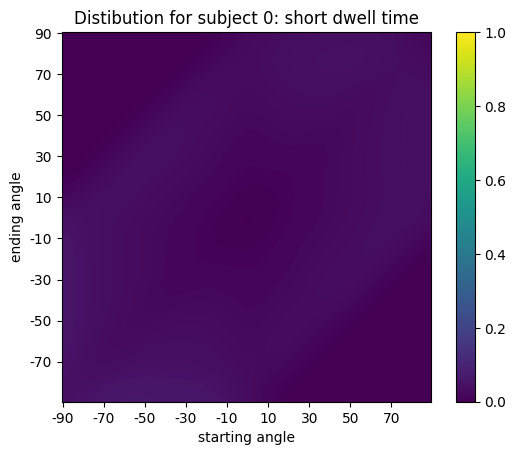

In [512]:
grid = np.zeros((180, 180))
grid_short_dwell = np.zeros((180, 180))
grid_long_dwell = np.zeros((180, 180))

# plot the neural network's prediction for the neck angles
angles_prev = np.arange(-90, 90, 5)
angles_current = np.arange(-90, 90, 5)
duration_long = 1
duration_short = 0.1
for a_prev in angles_prev:
    for a_cur in angles_current:
        if np.abs(a_prev - a_cur) <= 90 and a_prev != a_cur:
            input_vector = [a_cur, a_prev, duration_long]
            input_vector = torch.tensor(input_vector, dtype=torch.float32)
            output_long = model(input_vector)
            
            input_vector = [a_cur, a_prev, duration_short]
            input_vector = torch.tensor(input_vector, dtype=torch.float32)
            output_short = model(input_vector)
            
            grid[a_prev + 90, a_cur + 90] += output_short.detach().numpy()
            grid[a_prev + 90, a_cur + 90] += output_long.detach().numpy()
            grid_short_dwell[a_prev + 90, a_cur + 90] += output_short.detach().numpy()
            grid_long_dwell[a_prev + 90, a_cur + 90] += output_long.detach().numpy()

grid = scipy.ndimage.gaussian_filter(grid, sigma=sigmaa)
plt.imshow(np.flip(grid, axis=0))
plt.title("Distibution for subject {}: long dwell time".format(tup_i))
plt.xlabel("starting angle")
plt.ylabel("ending angle")
plt.xticks(np.arange(0, 180, 20), np.arange(-90, 90, 20))
plt.yticks(np.arange(0, 180, 20), -np.arange(-90, 90, 20))
plt.clim(0,1)  # identical to caxis([-4,4]) in MATLAB
plt.colorbar()
plt.show()
